<a href="https://colab.research.google.com/github/ParagAB/Lenders-Club-Loan-Defaulters-Prediction/blob/master/Lending_Club_Loan_Defaulter_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club Loan Defaulter Prediction

![alt text](https://www.lendingclub.com/asset/ls/wp-assets/wp-content/uploads/2017/05/LC-Logo-Official-min.png)

The aim of this project is to build a predictive machine learning tool to classify the loan defaulters and non-defaulters based on their profile. It is important for investors and lenders to know their borrower so they could determine the chances of getting their funds back before lending the money. Lenders, investors could use this model to decide whether a borrower is a fit for sanctioning a loan or not.

Dataset link - [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data)

**NOTE:** The following notebook requires specific technical architecture to run some of the operations.
The Rapids library requires Nvidia graphics card with Pascal architecture
This notebook is running on the following instance of GPU

In [ ]:
!nvidia-smi

Sun Apr 12 23:26:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

# Connect Google Drive to your notebook

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile({'q': "'1xJE20zntYdIqwQw2N1qrVomCPYZfWbWi' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

In [ ]:
csv_file = drive.CreateFile({'id': '1Ci-NyI8N2IWEY2iRkXphZAUZaTQIsgL6'})
xls_file = drive.CreateFile({'id':'1iBDwMoY-yUp3WpVMDYNlxj6-RbPnthPg'})

csv_file.GetContentFile('loan.csv')
xls_file.GetContentFile('LCDataDictionary.xlsx')

In [ ]:
import pandas as pd
import time
import cudf
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
import plotly.graph_objects as go
import numpy as np

# model analysis
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from xgboost import XGBClassifier


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Authorize the google drive and mount it on google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Time required to load the file using pandas

In [ ]:
st = time.time()
cdf = pd.read_csv('drive/My Drive/Lending_Club_Dataset/loan.csv')
print('Loading time {t:3.8f}'.format(t=time.time()-st))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading time 49.58097792


Nvidia Rapids uses GPU resources to load the data into Cuda Dataframe. Which is much faster compared to regular pandas DataFrame

In [ ]:
#To load file make folder in your drive called Lending_Club_Dataset and copy loans.csv file in that folder
#or change the the following path to your local directory(run next cell)
st = time.time()
cud = cudf.read_csv('drive/My Drive/Lending_Club_Dataset/loan.csv')
print('Loading time {t:3.8f}'.format(t=time.time()-st))

Loading time 3.69622064


In [ ]:
# st = time.time()
# cud = cudf.read_csv('loan.csv')
# print('Loading time {t:3.8f}'.format(t=time.time()-st))

In [ ]:
#There is a document provided along with dataset which is a data dictionary for the lendingclub dataset. Let's import that file
dataDict = pd.read_excel("LCDataDictionary.xlsx")

## Data Cleaning

Lets find Null Values from all columns

In [ ]:
nulls = cudf.DataFrame()
nulls['CountofNull'] = cud.isnull().sum()
nulls['Percent'] = (cud.isnull().sum()*100)/len(cud)
nulls[nulls['CountofNull']>0]
nulls.sort_values(by='Percent',ascending=False)
nulls[nulls['Percent']>20.0]

,CountofNull,Percent
id,2260668,100.000000
member_id,2260668,100.000000
url,2260668,100.000000
desc,2134601,94.423462
mths_since_last_delinq,1158502,51.246003
mths_since_last_record,1901512,84.112837
next_pymnt_d,1303607,57.664681
mths_since_last_major_derog,1679893,74.309585
annual_inc_joint,2139958,94.660428
dti_joint,2139962,94.660605


There are many columns present in the dataset which are mostly null. So we'll remove all the columns where 80% or more rows are null

In [ ]:
  cdf = cud.dropna(axis=1, thresh=int(0.80*len(cud)))
del cud
del nulls

## EDA

In [ ]:
cdf.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,109xx,NY,18.24,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,713xx,LA,26.52,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,490xx,MI,10.51,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,985xx,WA,16.74,2.0,7.0,2.0,3.0,2.0,10.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,212xx,MD,26.35,8.0,9.0,6.0,15.0,2.0,12.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N


## Data Dictionary

In [ ]:
dataDict

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [ ]:
dt_series = pd.to_datetime(cdf.to_pandas()['issue_d'])
cdf['year'] = dt_series.dt.year

The average loan amount issued by year

Text(0, 0.5, 'Average loan amount issued')

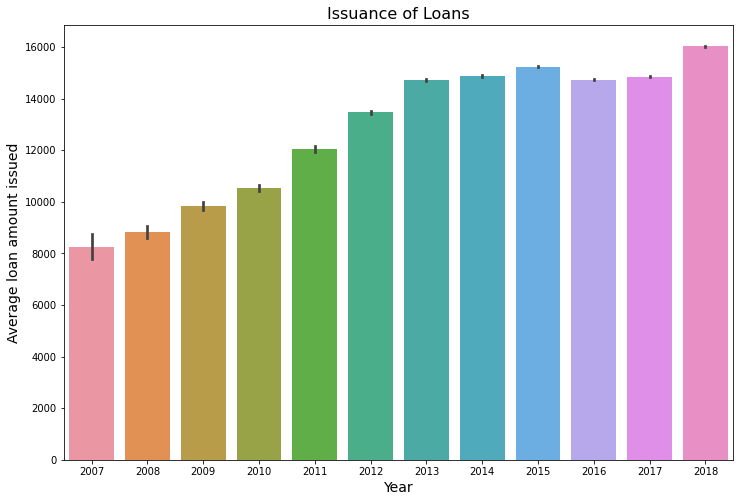

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amnt', data=cdf)
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

So how are these borrowers are getting paid on average in a year

Text(0, 0.5, 'Income')

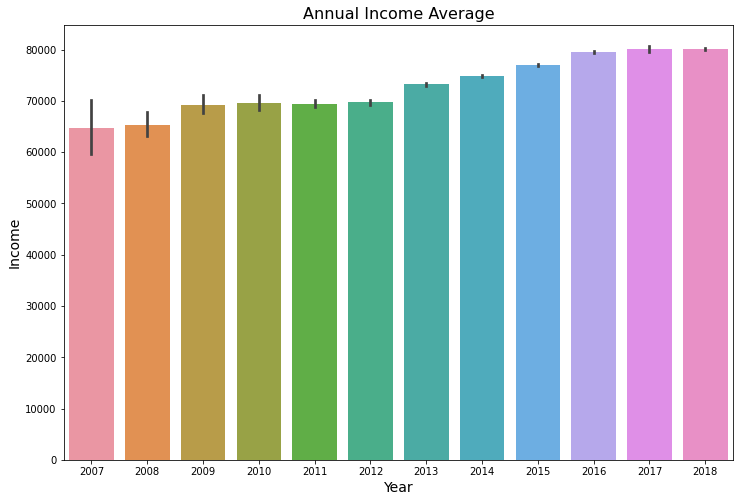

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot('year', 'annual_inc', data=cdf)
plt.title('Annual Income Average', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Income', fontsize=14)

Loan Categories by Lendeing Club

In [ ]:
cdf.loan_status.unique()

0                                          Charged Off
1                                              Current
2                                              Default
3    Does not meet the credit policy. Status:Charge...
4    Does not meet the credit policy. Status:Fully ...
5                                           Fully Paid
6                                      In Grace Period
7                                    Late (16-30 days)
8                                   Late (31-120 days)
Name: loan_status, dtype: object

Total count of loans given by lending club grouped by each category 

In [ ]:
cdf.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int32

We can see the various categories of loans here. Majority of loans are fully paid. However we need to understand that loans which are in 'Current' period have risk of defaulting.

Lets merge all the bad loan categories together since they have already passed the repayment period.

In [ ]:
#I'll not worry about the current loans and paid loans for now. We'll drop those categories for now.
cdf = cdf[cdf.loan_status != 'Current']
cdf = cdf[cdf.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
cdf = cdf[cdf.loan_status != 'Late (31-120 days)']
cdf = cdf[cdf.loan_status != 'Late (16-30 days)']


# bad_loan = ["Charged Off", "Late (16-30 days)","In Grace Period",  "Late (31-120 days)", 
#             "Does not meet the credit policy. Status:Charged Off","Default" ]
# def merge_status(status):
#     if status in bad_loan:
#         return 'Default'
#     else:
#         return 'Non-Default'
#cud['loan_condition'] = ['Default' if status in bad_loan else 'Non-Default' for status in cud['loan_status'] ]

cdf['loan_status'] = cdf['loan_status'].replace("Fully Paid","Non-Default")
cdf['loan_status'] = cdf['loan_status'].replace('Charged Off','Default')
cdf['loan_status'] = cdf['loan_status'].replace('In Grace Period','Default')
cdf['loan_status'] = cdf['loan_status'].replace('Does not meet the credit policy. Status:Default','Default')

Let's visualize the number of defaulted and non defaulted loans

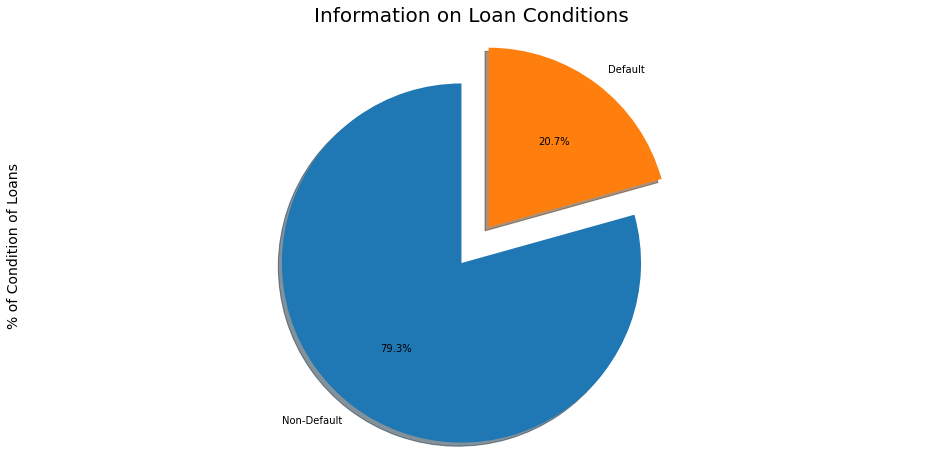

In [ ]:
loan_status = cdf.loan_status.value_counts()
labels ="Non-Default", "Default"

fig1, ax1 = plt.subplots(figsize=(16,8))
loan_status.to_pandas().plot.pie(explode=[0,0.25], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.ylabel('% of Condition of Loans', fontsize=14)
plt.title('Information on Loan Conditions', fontsize=20)

plt.show()

We can see from the piechart that the heavily unbalanced which could make the model biased. We'll handle it later.

Text(0, 0.5, 'Data type')

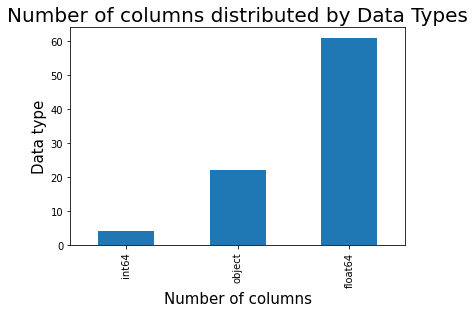

In [ ]:
#When given a quick glance we can see many non-numeric features. Lets check mumber of each type of column
cdf.dtypes.value_counts().sort_values().plot(kind='bar')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [ ]:
cdf.select_dtypes('object').head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
100,36 months,D,D5,Supervisor,5 years,MORTGAGE,Source Verified,Dec-2018,Non-Default,n,debt_consolidation,Debt consolidation,917xx,CA,Jan-2012,w,Jan-2019,Jan-2019,Joint App,N,Cash,N
152,60 months,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,Verified,Dec-2018,Non-Default,n,credit_card,Credit card refinancing,456xx,OH,Jun-2009,w,Feb-2019,Feb-2019,Joint App,N,Cash,N
170,36 months,A,A3,Teacher,10+ years,MORTGAGE,Not Verified,Dec-2018,Non-Default,n,credit_card,Credit card refinancing,982xx,WA,Feb-1999,w,Feb-2019,Feb-2019,Joint App,N,Cash,N
186,36 months,B,B3,Accounts Examiner III,10+ years,RENT,Not Verified,Dec-2018,Non-Default,n,credit_card,Credit card refinancing,786xx,TX,Dec-2003,w,Feb-2019,Feb-2019,Individual,N,Cash,N
215,36 months,E,E5,Senior Director Risk Management,3 years,MORTGAGE,Verified,Dec-2018,Non-Default,n,credit_card,Credit card refinancing,020xx,MA,Oct-1997,w,Feb-2019,Feb-2019,Joint App,N,Cash,N


In [ ]:
#Number of Categories each column has
cdf.to_pandas().select_dtypes('object').apply(pd.Series.nunique, axis = 0)

term                         2
grade                        7
sub_grade                   35
emp_title               373513
emp_length                  11
home_ownership               6
verification_status          3
issue_d                    139
loan_status                  2
pymnt_plan                   2
purpose                     14
title                    62108
zip_code                   944
addr_state                  51
earliest_cr_line           738
initial_list_status          2
last_pymnt_d               135
last_credit_pull_d         139
application_type             2
hardship_flag                2
disbursement_method          2
debt_settlement_flag         2
dtype: int64

We'll encode columns using one hot encoding where necessary. But there are few columns like emp_title, title,zip_code these needs to be dropped for now. Also I'll drop the debt settlement flag since it'll be correlated to the target variable since I dropped other categories from the loan status and we have only two categories in our dependent variable

In [ ]:
cdf = cdf.drop(columns=['emp_title','title','zip_code','debt_settlement_flag','earliest_cr_line','last_credit_pull_d'])

number of total null values from the column employment length 76044


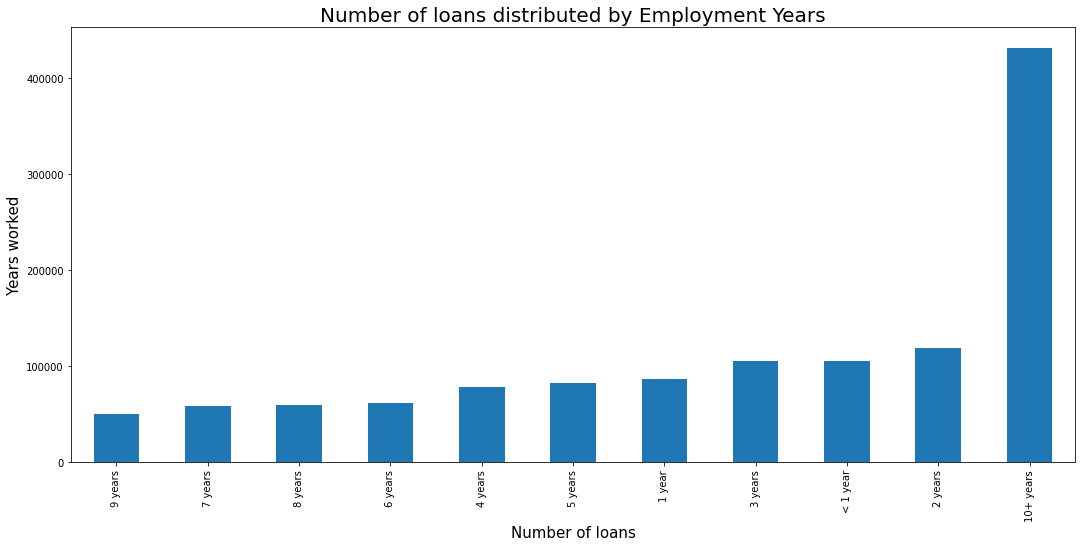

In [ ]:
print('number of total null values from the column employment length {}'.format(cdf.emp_length.isnull().sum()))

cdf.emp_length.to_pandas().value_counts().sort_values().plot(kind='bar',figsize=(18,8))
plt.title('Number of loans distributed by Employment Years',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Years worked',fontsize=15);

The number of null values are few compared to the categorical distribution and total dataset. So we can make a seperate category for the missing values with 0 years of experience also there is similar category already present category '<1'. So I'll fill the missing data with 0 and make replace all the '<1' year with 0
'

In [ ]:
cdf['emp_length']= cdf['emp_length'].replace(to_replace='< 1 year', replacement='0')
cdf['emp_length'].fillna(value='0',inplace=True)
cdf['emp_length']= cdf['emp_length'].replace(to_replace='[^0-9]+', replacement='')
cdf.emp_length.value_counts()

10    431613
0     181560
2     118752
3     105029
1      86360
5      82227
4      78650
6      61408
8      59499
7      58486
9      49767
Name: emp_length, dtype: int32

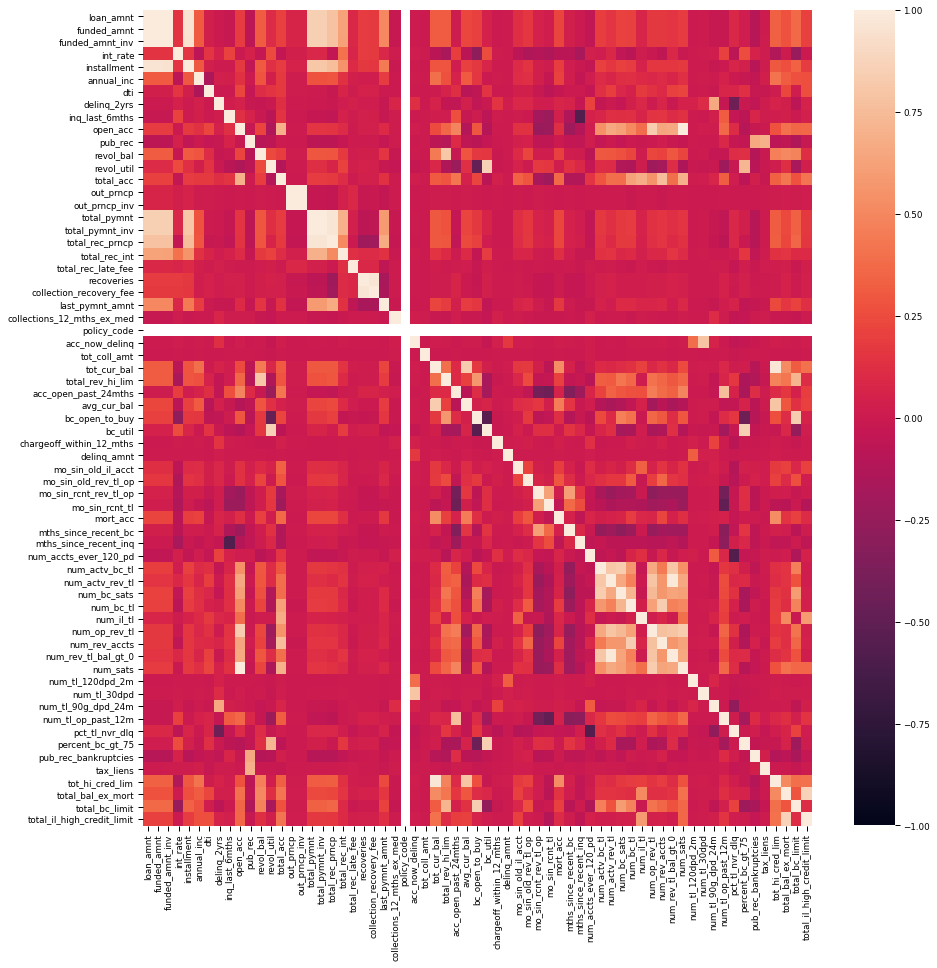

In [ ]:
plt.figure(figsize=(15,15))
sns.set_context("paper", font_scale=1)
correlationdf = cdf.to_pandas().corr()
sns.heatmap(correlationdf,vmin=-1, vmax=1)

From the heat map we can see that the loan amount and loan installment have really hight correlation with each other, which makes sense. If you have big loan amount then obviously your installment will be big as well

In [ ]:
num_feat = cdf.select_dtypes('int64').columns.values
cdf[num_feat].to_pandas().nunique().sort_values()

policy_code        1
loan_amnt       1556
funded_amnt     1556
revol_bal      83108
dtype: int64

In [ ]:
cdf.drop(columns=['installment','policy_code'])

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method
100,30000,30000,30000.0,36 months,22.35,D,D5,5,MORTGAGE,100000.0,Source Verified,Dec-2018,Non-Default,n,debt_consolidation,CA,30.46,0.0,0.0,11.0,1.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,N,Cash
152,40000,40000,40000.0,60 months,16.14,C,C4,0,MORTGAGE,45000.0,Verified,Dec-2018,Non-Default,n,credit_card,OH,50.53,0.0,0.0,18.0,0.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,N,Cash
170,20000,20000,20000.0,36 months,7.56,A,A3,10,MORTGAGE,100000.0,Not Verified,Dec-2018,Non-Default,n,credit_card,WA,18.92,0.0,0.0,9.0,0.0,5.0,6.0,5.0,5.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,94.7,20.0,0.0,0.0,622183.0,71569.0,85100.0,74833.0,N,Cash
186,4500,4500,4500.0,36 months,11.31,B,B3,10,RENT,38500.0,Not Verified,Dec-2018,Non-Default,n,credit_card,TX,4.64,0.0,0.0,12.0,0.0,5.0,6.0,10.0,11.0,15.0,5.0,12.0,0.0,0.0,0.0,4.0,91.7,0.0,0.0,0.0,53795.0,29137.0,15100.0,24595.0,N,Cash
215,8425,8425,8425.0,36 months,27.27,E,E5,3,MORTGAGE,450000.0,Verified,Dec-2018,Non-Default,n,credit_card,MA,12.37,0.0,0.0,21.0,0.0,8.0,10.0,16.0,13.0,17.0,8.0,21.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,768304.0,189194.0,45800.0,189054.0,N,Cash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260655,18000,18000,18000.0,60 months,30.65,F,F4,10,MORTGAGE,77000.0,Verified,Oct-2017,Default,n,debt_consolidation,TX,8.08,0.0,1.0,9.0,0.0,4.0,4.0,7.0,6.0,6.0,5.0,9.0,0.0,0.0,0.0,5.0,93.3,50.0,0.0,0.0,338546.0,18113.0,13800.0,7058.0,N,Cash
2260656,17950,17950,17950.0,60 months,30.17,F,F3,10,MORTGAGE,53758.0,Source Verified,Oct-2017,Non-Default,n,debt_consolidation,IL,33.24,0.0,1.0,11.0,1.0,1.0,4.0,7.0,7.0,14.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,1.0,0.0,203667.0,36652.0,4000.0,63002.0,N,Cash
2260658,15000,15000,15000.0,60 months,16.02,C,C5,0,RENT,85000.0,Verified,Oct-2017,Non-Default,n,debt_consolidation,NY,14.66,0.0,3.0,19.0,0.0,8.0,17.0,55.0,13.0,31.0,6.0,19.0,0.0,0.0,0.0,7.0,89.0,0.0,0.0,0.0,267274.0,239081.0,22900.0,239074.0,N,Cash
2260661,21000,21000,21000.0,60 months,30.94,G,G4,0,MORTGAGE,90000.0,Verified,Oct-2017,Default,n,medical,GA,26.44,1.0,2.0,8.0,0.0,2.0,5.0,17.0,4.0,10.0,4.0,8.0,0.0,0.0,0.0,3.0,86.2,50.0,0.0,0.0,328405.0,68445.0,1300.0,57142.0,N,Cash


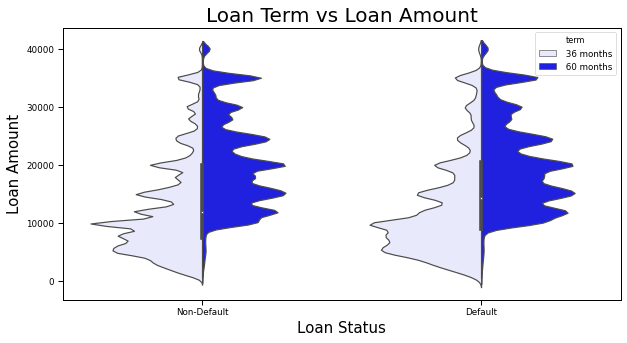

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.violinplot(x="loan_status",y="loan_amnt",data=cdf.to_pandas(), hue="term", split=True,color='blue')
plt.title("Loan Term vs Loan Amount", fontsize=20)
plt.xlabel("Loan Status", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

Loans with higher amount have higher term

Converting features with 2 categories using label encoders to 1 and 0

In [ ]:
#before encoding the features lets make sure that there are no nulls

categories = cdf.to_pandas().select_dtypes('object').apply(pd.Series.nunique, axis=0)
categories.where(categories==2).dropna()


term                   2.0
loan_status            2.0
pymnt_plan             2.0
initial_list_status    2.0
application_type       2.0
hardship_flag          2.0
disbursement_method    2.0
dtype: float64

In [ ]:
count = 0

for col in cdf:
    if cdf[col].dtype == 'object':
        if len(list(cdf[col].unique())) <= 2:     
            leb = LabelEncoder()
            cdf[col] = leb.fit_transform(cdf.to_pandas()[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

term
loan_status
pymnt_plan
initial_list_status
application_type
hardship_flag
disbursement_method
7 columns were label encoded.


In [ ]:
#We have still have categorical variables in these columns
cdf.to_pandas().select_dtypes('object').apply(pd.Series.nunique, axis = 0)

grade                    7
sub_grade               35
emp_length              11
home_ownership           6
verification_status      3
issue_d                139
purpose                 14
addr_state              51
last_pymnt_d           135
dtype: int64

In [ ]:
cdf['issue_d']=pd.to_datetime(cdf.to_pandas()['issue_d']).apply(lambda x: int(x.strftime('%Y')))
cdf['last_pymnt_m'] = pd.to_datetime(cdf.to_pandas()['last_pymnt_d'].fillna('2018-08-01')).apply(lambda x: int(x.strftime('%m')))
cdf['last_pymnt_y'] = pd.to_datetime(cdf.to_pandas()['last_pymnt_d'].fillna('2018-08-01')).apply(lambda x: int(x.strftime('%Y')))

In [ ]:
#lets drop the last_pymnt_d since we have already converted it
cdf.drop(columns=['last_pymnt_d'],inplace=True)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,last_pymnt_m,last_pymnt_y
100,30000,30000,30000.0,0,22.35,1151.16,D,D5,5,MORTGAGE,100000.0,Source Verified,2018,1,0,debt_consolidation,CA,30.46,0.0,0.0,11.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,0,0,1,2019
152,40000,40000,40000.0,1,16.14,975.71,C,C4,0,MORTGAGE,45000.0,Verified,2018,1,0,credit_card,OH,50.53,0.0,0.0,18.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,0,0,2,2019
170,20000,20000,20000.0,0,7.56,622.68,A,A3,10,MORTGAGE,100000.0,Not Verified,2018,1,0,credit_card,WA,18.92,0.0,0.0,9.0,5.0,5.0,9.0,5.0,9.0,0.0,0.0,0.0,1.0,94.7,20.0,0.0,0.0,622183.0,71569.0,85100.0,74833.0,0,0,2,2019
186,4500,4500,4500.0,0,11.31,147.99,B,B3,10,RENT,38500.0,Not Verified,2018,1,0,credit_card,TX,4.64,0.0,0.0,12.0,10.0,11.0,15.0,5.0,12.0,0.0,0.0,0.0,4.0,91.7,0.0,0.0,0.0,53795.0,29137.0,15100.0,24595.0,0,0,2,2019
215,8425,8425,8425.0,0,27.27,345.18,E,E5,3,MORTGAGE,450000.0,Verified,2018,1,0,credit_card,MA,12.37,0.0,0.0,21.0,16.0,13.0,17.0,8.0,21.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,768304.0,189194.0,45800.0,189054.0,0,0,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260655,18000,18000,18000.0,1,30.65,589.57,F,F4,10,MORTGAGE,77000.0,Verified,2017,0,0,debt_consolidation,TX,8.08,0.0,1.0,9.0,7.0,6.0,6.0,5.0,9.0,0.0,0.0,0.0,5.0,93.3,50.0,0.0,0.0,338546.0,18113.0,13800.0,7058.0,0,0,8,2018
2260656,17950,17950,17950.0,1,30.17,582.62,F,F3,10,MORTGAGE,53758.0,Source Verified,2017,1,0,debt_consolidation,IL,33.24,0.0,1.0,11.0,7.0,7.0,14.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,1.0,0.0,203667.0,36652.0,4000.0,63002.0,0,0,4,2018
2260658,15000,15000,15000.0,1,16.02,364.94,C,C5,0,RENT,85000.0,Verified,2017,1,0,debt_consolidation,NY,14.66,0.0,3.0,19.0,55.0,13.0,31.0,6.0,19.0,0.0,0.0,0.0,7.0,89.0,0.0,0.0,0.0,267274.0,239081.0,22900.0,239074.0,0,0,3,2018
2260661,21000,21000,21000.0,1,30.94,691.60,G,G4,0,MORTGAGE,90000.0,Verified,2017,0,0,medical,GA,26.44,1.0,2.0,8.0,17.0,4.0,10.0,4.0,8.0,0.0,0.0,0.0,3.0,86.2,50.0,0.0,0.0,328405.0,68445.0,1300.0,57142.0,0,0,2,2019


Convert those categorical features from non-integer to integer

In [ ]:
cdf = pd.get_dummies(cdf.to_pandas(),drop_first=True)

In [ ]:
cdf['mths_since_recent_inq'] = cdf['mths_since_recent_inq'].fillna(cdf['mths_since_recent_inq'].median())
cdf['num_tl_120dpd_2m'] = cdf['num_tl_120dpd_2m'].fillna(cdf['num_tl_120dpd_2m'].median())
cdf['mo_sin_old_il_acct'] = cdf['mo_sin_old_il_acct'].fillna(cdf['mo_sin_old_il_acct'].median())

In [ ]:
cdf.dropna(inplace=True)

In [ ]:
cdf.to_csv('DatasetProcessed.csv')

### Data Preparation for model
coverting data to training and testing sets.
Splitting dataset into 80-20 ratio

In [ ]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(cdf.drop('loan_status',axis=1),cdf['loan_status'],test_size=0.20)

Model Evaluation

In [ ]:
def modelScore(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("Accuracy Score: {0:.5f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    
        

In [ ]:
def modelScoreXGB(xgb,y_test,y_pred):
  cm = confusion_matrix(y_test, (y_pred>0.5))
  print('The Confusion Matrix is: ','\n', cm)

  # Calculate the accuracy on test set
  accuracy_test = (accuracy_score(y_test, (y_pred>0.5)))
  print('The Accuracy on Test Set is: {}'.format(accuracy_test))
  print("Classification Report: \n {}\n".format(classification_report(y_test, (y_pred>0.5))))

## Model Designing

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
t = time.time()
clf_rf = RandomForestClassifier(n_estimators=50, random_state=21,n_jobs=-1)
clf_rf.fit(X_train, y_train)
print('Time to train the model {}'.format(time.time()-t))

Time to train the model 99.60076642036438


In [ ]:
t = time.time()
modelScore(clf_rf,X_train,y_train,X_test,y_test)
print('Time for Cross validation- {}'.format(time.time()-t))

Train Result:

Accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    205729
           1       1.00      1.00      1.00    778448

    accuracy                           1.00    984177
   macro avg       1.00      1.00      1.00    984177
weighted avg       1.00      1.00      1.00    984177


Confusion Matrix: 
 [[205726      3]
 [     0 778448]]

Average Accuracy: 	 0.9961
Time for Cross validation- 451.18876814842224


We can see from the cross validation that the model is trained well. We see some consistent accuracy there which means that the model is well trained and can be used for prediction

### Let's test the model with out of sample data

In [ ]:
modelScore(clf_rf,X_train,y_train,X_test,y_test,train=False)

Test Result:

Accuracy Score: 0.99633

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     51336
           1       1.00      1.00      1.00    194709

    accuracy                           1.00    246045
   macro avg       1.00      0.99      0.99    246045
weighted avg       1.00      1.00      1.00    246045


Confusion Matrix: 
 [[ 50432    904]
 [     0 194709]]



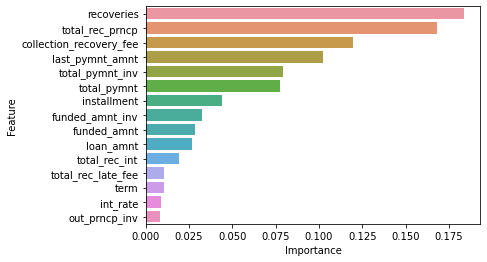

In [ ]:
features = X_train.columns.values
impt = clf_rf.feature_importances_
df = pd.DataFrame({'Feature': features, 'Importance': impt})
df = df.sort_values('Importance', ascending=False)[:15]
sns.barplot(x='Importance', y='Feature', data=df)


The previous model is trained with full computational power i.e 8 cores.
Lets see the training time and performace by changing the number of cores

In [ ]:
elapsed_time=[]

for cores in [1,2,-1]:
  t = time.time()
  clf_rf = RandomForestClassifier(n_estimators=100, random_state=21,n_jobs=cores,verbose=1)
  clf_rf.fit(X_train, y_train)
  elapsed = time.time()-t
  elapsed_time.append(elapsed)
  print('Time to train the model {}'.format(elapsed))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.5min finished


Time to train the model 632.7417728900909


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  5.5min finished


Time to train the model 332.4882299900055


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min


Time to train the model 251.53646326065063


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


In [ ]:
#Lets plot the graps for run time
cores = [1,2,4]

fig =go.Figure()
fig.add_trace(go.Scatter(x=cores,y=elapsed_time,mode='lines+markers'))

fig.update_layout(title='Random Forest training time vs number of cores',
                  xaxis_title='Number of Threads',
                  yaxis_title= 'Speed (seconds)')
fig.show()

The catboost library implements gradient boosting algorithm on GPU memory
To install catboost you can use pip install catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool
model = CatBoostClassifier(iterations=100,
                           depth=15,
                           learning_rate=0.01,
                           loss_function='Logloss',
                           verbose=True)

In [ ]:
t = time.time()
model.fit(X_train,y_train)
print('Elapsed time-{}'.format(time.time()-t))

In [ ]:
#lets see how model performs during k-fold cross validation

In [ ]:
t = time.time()
modelScore(model,X_train,y_train,X_test,y_test)
print('Elapsed time-{}'.format(time.time()-t))

Train Result:

Accuracy score: 0.9972

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    205730
           1       1.00      1.00      1.00    778447

    accuracy                           1.00    984177
   macro avg       1.00      0.99      1.00    984177
weighted avg       1.00      1.00      1.00    984177


Confusion Matrix: 
 [[202968   2762]
 [     3 778444]]

0:	learn: 0.6618609	total: 3.8s	remaining: 6m 16s
1:	learn: 0.6317375	total: 7.07s	remaining: 5m 46s
2:	learn: 0.6097457	total: 10.4s	remaining: 5m 35s
3:	learn: 0.5823722	total: 13.6s	remaining: 5m 25s
4:	learn: 0.5585187	total: 16.8s	remaining: 5m 18s
5:	learn: 0.5405720	total: 20s	remaining: 5m 13s
6:	learn: 0.5149200	total: 23.2s	remaining: 5m 8s
7:	learn: 0.4955864	total: 24.9s	remaining: 4m 46s
8:	learn: 0.4736492	total: 28.1s	remaining: 4m 44s
9:	learn: 0.4565964	total: 31.3s	remaining: 4m 41s
10:	learn: 0.4404045	total: 34.5s	remaining: 4

In [ ]:
modelScore(model,X_train,y_train,X_test,y_test,train=False)

Test Result:

Accuracy Score: 0.99713

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     51335
           1       1.00      1.00      1.00    194710

    accuracy                           1.00    246045
   macro avg       1.00      0.99      1.00    246045
weighted avg       1.00      1.00      1.00    246045


Confusion Matrix: 
 [[ 50628    707]
 [     0 194710]]



The model training time was bit slower compared to random forest model. However we see very poor performance for validation.
The model did not perform well on training dataset. There are over 2000 obervations which are classified incorrectly. The recall and precision is low compared to random forest model.
However the testing accuracy was better than random forest model. THe precsion and recall is better as well. 

Lets train the same model with GPU with same parameters

In [ ]:
GPU_model = CatBoostClassifier(iterations=100,
                           depth=15,
                           learning_rate=0.01,
                           loss_function='Logloss',
                           task_type='GPU')
t = time.time()
GPU_model.fit(X_train,y_train)
print('Elapsed time-{}'.format(time.time()-t))

In [ ]:
t= time.time()
modelScore(GPU_model,X_train,y_train,X_test,y_test)
print('Elapsed time for model validation- {}'.format(time.time()-t))

Train Result:

Accuracy score: 0.9973

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    205730
           1       1.00      1.00      1.00    778447

    accuracy                           1.00    984177
   macro avg       1.00      0.99      1.00    984177
weighted avg       1.00      1.00      1.00    984177


Confusion Matrix: 
 [[203117   2613]
 [    25 778422]]

0:	learn: 0.6597871	total: 673ms	remaining: 1m 6s
1:	learn: 0.6281010	total: 1.33s	remaining: 1m 5s
2:	learn: 0.5993720	total: 1.45s	remaining: 46.8s
3:	learn: 0.5747125	total: 2.11s	remaining: 50.7s
4:	learn: 0.5481975	total: 2.49s	remaining: 47.4s
5:	learn: 0.5277921	total: 3.15s	remaining: 49.4s
6:	learn: 0.5034538	total: 3.82s	remaining: 50.7s
7:	learn: 0.4809163	total: 4.48s	remaining: 51.6s
8:	learn: 0.4593181	total: 5.15s	remaining: 52.1s
9:	learn: 0.4372970	total: 5.81s	remaining: 52.3s
10:	learn: 0.4171462	total: 6.48s	remaining: 52.4s
1

In [ ]:
modelScore(GPU_model,X_train,y_train,X_test,y_test,train=False)

Test Result:

Accuracy Score: 0.99720

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     51335
           1       1.00      1.00      1.00    194710

    accuracy                           1.00    246045
   macro avg       1.00      0.99      1.00    246045
weighted avg       1.00      1.00      1.00    246045


Confusion Matrix: 
 [[ 50652    683]
 [     5 194705]]



Feature Importance

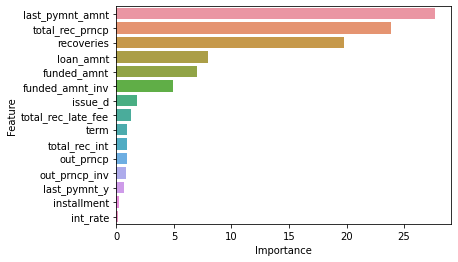

In [ ]:
features = X_train.columns.values
impt = GPU_model.feature_importances_
df = pd.DataFrame({'Feature': features, 'Importance': impt})
df = df.sort_values('Importance', ascending=False)[:15]
sns.barplot(x='Importance', y='Feature', data=df)

The model performed well on out of sample data. Still there are few misclassifications in predicting defaulters. We need to improve recall and f1-score.

The extreem gradient boosting might perform better and reduce the misclassified predictions

## XG Boosting

In [ ]:
params = {
    'max_depth':    8,
    'max_leaves':   2**8,
    'tree_method':  'gpu_hist',
    'objective':    'binary:logistic',
    'grow_policy':  'lossguide',
    'eval_metric':  'logloss',
    'subsample':    '0.8'
}

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train, y_train)

In [ ]:
t = time.time()
model = xgb.train(params, dtrain, num_boost_round=100)

print("Model Training time {n}".format(n=time.time()-t))

Model Training time 10.856779098510742


In [ ]:
modelScoreXGB(model,y_train,model.predict(dtrain))

The Confusion Matrix is:  
 [[205703     26]
 [     0 778448]]
The Accuracy on Test Set is: 0.9999735819877928
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    205729
           1       1.00      1.00      1.00    778448

    accuracy                           1.00    984177
   macro avg       1.00      1.00      1.00    984177
weighted avg       1.00      1.00      1.00    984177




In [ ]:
result_cv = xgb.cv(params=params,dtrain=dtrain,nfold=5,metrics={'auc'})

In [ ]:
result_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.996256,0.000057,0.996139,0.000115
1,0.997367,0.000251,0.997286,0.000216
2,0.998252,0.000032,0.998195,0.000125
3,0.998644,0.000118,0.998592,0.000135
4,0.998835,0.000097,0.998781,0.000098


In [ ]:
dtest = xgb.DMatrix(X_test)
%time y_pred = model.predict(dtest)

CPU times: user 2.06 s, sys: 0 ns, total: 2.06 s
Wall time: 531 ms


In [ ]:
cm = confusion_matrix(y_test, (y_pred>0.5))
print('The Confusion Matrix is: ','\n', cm)

# Calculate the accuracy on test set
accuracy_test = (accuracy_score(y_test, (y_pred>0.5)))
print('The Accuracy on Test Set is: {}'.format(accuracy_test))
print("Classification Report: \n {}\n".format(classification_report(y_test, (y_pred>0.5))))

The Confusion Matrix is:  
 [[ 51211    125]
 [     0 194709]]
The Accuracy on Test Set is: 0.9994919628523238
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     51336
           1       1.00      1.00      1.00    194709

    accuracy                           1.00    246045
   macro avg       1.00      1.00      1.00    246045
weighted avg       1.00      1.00      1.00    246045




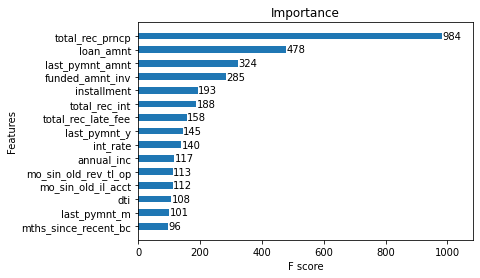

<Figure size 1800x864 with 0 Axes>

In [ ]:
ax = xgb.plot_importance(model, height=.5,max_num_features=15)
plt.figure(figsize=(25, 12))
ax.grid(False)
ax.set_title('Importance')
plt.show()

In [ ]:
import cupy as cp

y_test_cpu = cp.asnumpy(cp.array(y_test))
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test_cpu, y_pred)

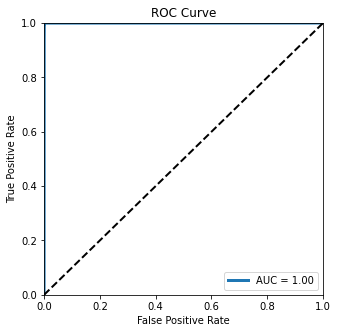

In [ ]:
auc_result = auc(false_pos_rate, true_pos_rate)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(false_pos_rate, true_pos_rate, lw=3,
        label='AUC = {:.2f}'.format(auc_result))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc='lower right');
plt.show()

## Conclusion

As we can see the XG boosting did great job at predicting with 99.9% accuracy. The precision and recall for model is 1.
The random forest model was slow compared to the XG boosting and gradient boosting. RF model predicted the out-of-sample data with 99.6% accuracy. However, the recall and f1-score is 98% and 99% respectively. 
When run time is compared the XGB trained model in just 10 seconds but RF was slower, it took around 2+ mins.